In [1]:
!pip install plotly

In [2]:
import numpy as np
import pandas as pd

# Reproducibility
np.random.seed(23) 

# ---------- Class 1 ----------
mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20)

df1 = pd.DataFrame(class1_sample, columns=['feature1','feature2','feature3'])
df1['target'] = 1

# ---------- Class 2 ----------
mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20)

df2 = pd.DataFrame(class2_sample, columns=['feature1','feature2','feature3'])
df2['target'] = 0

# ---------- Combine ----------
df = pd.concat([df1, df2], ignore_index=True)

# Shuffle rows
df = df.sample(frac=1, random_state=23).reset_index(drop=True)

print(df.head())


   feature1  feature2  feature3  target
0 -0.331617 -1.632386  0.619114       1
1  1.010229  1.437830  2.327788       0
2  0.241106 -0.952510 -0.136267       1
3  1.676860  4.187503 -0.080565       0
4  2.823378 -0.332863  2.637391       0


In [3]:
df.head()

,feature1,feature2,feature3,target
0,-0.331617,-1.632386,0.619114,1
1,1.010229,1.437830,2.327788,0
2,0.241106,-0.952510,-0.136267,1
3,1.676860,4.187503,-0.080565,0
4,2.823378,-0.332863,2.637391,0


In [4]:
import plotly.express as px

fig = px.scatter_3d(
    df, 
    x="feature1", 
    y="feature2", 
    z="feature3",
    color=df["target"].astype(str),  # convert target to string for coloring
    title="3D Scatter Plot of Synthetic Dataset"
)

fig.update_traces(
    marker=dict(size=12,
                line=dict(width=2, color='DarkSlateGrey')),
    selector=dict(mode='markers')
)

fig.show()


In [5]:
# Step 1 - Apply standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df.iloc[:,0:3] = scaler.fit_transform(df.iloc[:,0:3])

In [6]:
# Step 2 - Find Covariance Matrix
covariance_matrix = np.cov([df.iloc[:,0],df.iloc[:,1],df.iloc[:,2]])
print('Covariance Matrix:\n', covariance_matrix)

Covariance Matrix:
 [[1.02564103 0.20478114 0.080118  ]
 [0.20478114 1.02564103 0.19838882]
 [0.080118   0.19838882 1.02564103]]


In [7]:
# Step 3 - Finding EV and EVs
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

In [8]:
eigen_values

array([1.3536065 , 0.94557084, 0.77774573])

In [9]:
eigen_vectors

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442],
       [-0.52848211,  0.72025103,  0.44938304]])

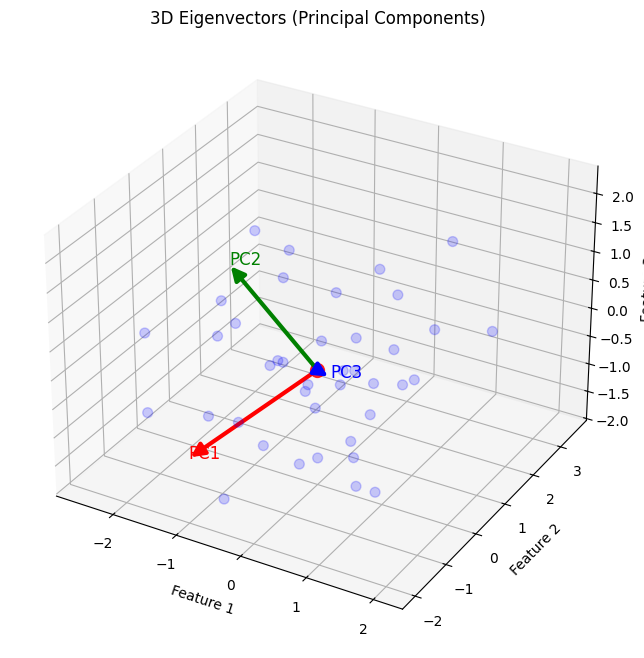

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

# --------- Arrow3D class ----------
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.get_proj())
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.get_proj())
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

# --------- Plotting ----------
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Scatter points
ax.scatter(df['feature1'], df['feature2'], df['feature3'],
           color='blue', alpha=0.2, s=50)

# Mean point
mean_x, mean_y, mean_z = df['feature1'].mean(), df['feature2'].mean(), df['feature3'].mean()
ax.scatter(mean_x, mean_y, mean_z, color='red', s=100, alpha=0.8)

# Draw eigenvectors (principal components)
colors = ["r", "g", "b"]  # PC1, PC2, PC3
for i in range(len(eigen_vectors)):
    vec = eigen_vectors[:, i] * np.sqrt(eigen_values[i]) * 2  # scale by variance
    arrow = Arrow3D([mean_x, mean_x + vec[0]],
                    [mean_y, mean_y + vec[1]],
                    [mean_z, mean_z + vec[2]],
                    mutation_scale=20, lw=3, arrowstyle="-|>", color=colors[i])
    ax.add_artist(arrow)
    ax.text(mean_x + vec[0], mean_y + vec[1], mean_z + vec[2],
            f"PC{i+1}", color=colors[i], fontsize=12)

# Labels
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.title("3D Eigenvectors (Principal Components)")

plt.show()


In [11]:
pc = eigen_vectors[0:2]
pc

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442]])

In [12]:
# Step 1: Sort eigenvalues and eigenvectors
eig_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(len(eigen_values))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)  # sort by eigenvalue descending

# Step 2: Take the top 2 eigenvectors
pc = np.array([eig_pairs[0][1], eig_pairs[1][1]])  # shape (2, 3)
# We need shape (3,2) for dot product, so take transpose
pc = pc.T  # now shape is (3,2)

# Step 3: Transform original data
transformed_df = np.dot(df.iloc[:, 0:3].values, pc)  # shape (40,2)

# Step 4: Create new DataFrame
new_df = pd.DataFrame(transformed_df, columns=['PC1','PC2'])
new_df['target'] = df['target'].values

new_df.head()


,PC1,PC2,target
0,1.694055,0.454694,1
1,-1.654764,0.691473,0
2,1.349328,-0.377883,1
3,-2.572050,-1.265530,0
4,-1.544065,-0.194608,0


In [13]:
new_df['target'] = new_df['target'].astype('str')
fig = px.scatter(x=new_df['PC1'],
                 y=new_df['PC2'],
                 color=new_df['target'],
                 color_discrete_sequence=px.colors.qualitative.G10
                )

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()